# Network Flow

In [1]:
import numpy as np
import networkx as nx
import queue

import typing
import tqdm

ok = """
         _          _                  _           _        
        /\ \       / /\               / /\        / /\      
       /  \ \     / /  \             / /  \      / /  \     
      / /\ \ \   / / /\ \           / / /\ \__  / / /\ \__  
     / / /\ \_\ / / /\ \ \         / / /\ \___\/ / /\ \___\ 
    / / /_/ / // / /  \ \ \        \ \ \ \/___/\ \ \ \/___/ 
   / / /__\/ // / /___/ /\ \        \ \ \       \ \ \       
  / / /_____// / /_____/ /\ \   _    \ \ \  _    \ \ \      
 / / /      / /_________/\ \ \ /_/\__/ / / /_/\__/ / /      
/ / /      / / /_       __\ \_\\ \/___/ /  \ \/___/ /       
\/_/       \_\___\     /____/_/ \_____\/    \_____\/        
                                                            
"""

In [2]:
try:
    nx.gnp_random_graph(7, 0.65, seed=np.random.default_rng(seed=1145141919), directed=True)
    prng = np.random.default_rng(seed=114514)
except Exception as e:
    prng = np.random.RandomState(seed=1919810)

In [3]:
prng1 = np.random.default_rng(seed=114514)

In [4]:
def rand_graph() -> nx.DiGraph:
    random_graph = nx.gnp_random_graph(prng1.integers(16, 64), 0.25, seed=prng, directed=True)
    for u, v in random_graph.edges:
        random_graph.edges[u, v]["capacity"] = prng1.integers(0, 69)
        random_graph.edges[u, v]["flow"] = 0
    return random_graph

Here, we will implement one well-defined implementation of Ford–Fulkerson algorithm: Edmonds–Karp algorithm.

What Ford–Fulkerson does can be summarised as 3 steps:

0. Find an augmenting path in the graph
1. Construct the residual graph by augmenting the path based on the original graph and augmenting path
2. Do this until no augmenting path can be found.

Ford-Fulkerson is not well-defined because there could be multiple ways of doing step 0: by DFS, by A* search, by some RL model that takes 200 RTX A6000 to train, or by magic......  
If we use BFS to find the augmenting path, this algorithm is called Edmonds–Karp algorithm which is what we will implement today.  
Fun fact: Edmonds–Karp algorithm was first introduced by Soviet mathematician Yefim Dinitz/Dinic (Ефим Диниц for his Russian-speaking friends), yet Dinic Algorithm is the name of a more complex and efficient algorithm for Network Flow problems.

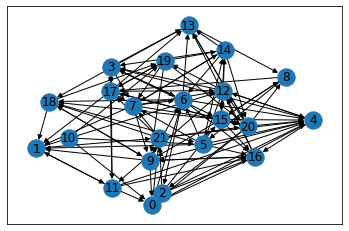

In [5]:
nx.draw_networkx(rand_graph())

## Augmenting Path

First, you will implement the BFS portion of Edmonds–Karp algorithm.  
Given a graph and `s` and `t` vertices, find a augmenting path (a list of vertices from `s` to `t` **including** `s` and `t`) with BFS. If there's no path, return None.

### Networkx tricks

There are some `networkx` tricks you might want to use below to make your life way easier:

To access flow from edge `(u, v)`, do `g.edges[u, v]["flow"]`; sub `flow` for `capacity` for capacity.

To access outgoing edges from `c` like adjacency list, do `g.edges(c)`. Note the returned type is an iterable of vertex tuples, so you should do something like:
```
for u, v in g.edges(c):
    e = g.edges[u, v]
    print(e["flow"])
```

To update an edge, use `g.add_edge(u, v, flow=0, capacity=1)` or `g.edges[u, v]["flow"] = 0`.

For the purpose of this coding HW, instead of decreasing `g.edges[u, v]["capacity"]` and check if it's still greater than zero each time you find or augment a path, please increase `g.edges[u, v]["flow"]` and check if it's still greater than `g.edges[u, v]["capacity"]`.

While `g.edges[u, v]` looks like adjacency matrix it is not - if (u, v) doesn't exist there would be `KeyError`.  
Later, when implementing `edmonds_karp()`, you are free to use `nx.algorithms.flow.build_residual_network` to avoid such matter.

In [27]:
from collections import deque
def traceBack(prev, s, t):
    rst = [t]
    c = t
    while c != -1 and c != s:
        if c in prev:
            c = prev[c]
            rst.append(c)
        else:
            break
        
    return list(reversed(rst))

def bfs_augmenting_path(g: nx.DiGraph, s: int, t: int) -> typing.Union[typing.List[int], None]:
    # Your code here
    toVisit = deque()
    visited = set()
    prev = {}
    
    toVisit.append(s)
    visited.add(s)
    
    while toVisit:
        current_node = toVisit.popleft()
        for u,v in g.edges(current_node):
            e = g.edges[u,v]
            #check if we can progress with u,v
            if v not in visited and e['flow'] < e['capacity']:
                toVisit.append(v)
                visited.add(v)
                prev[v] = u
                if v == t:
                    return traceBack(prev,s,t)
    
    #not found
    return None
                

In [28]:
for i in tqdm.tqdm(range(114)):
    random_graph = rand_graph()
    for _ in range(15):
        s = 0; t = 0
        while s == t:
            s = prng1.integers(0, len(random_graph))
            t = prng1.integers(0, len(random_graph))
        g_copy = random_graph.copy()
        edge_removal = []
        for u, v in g_copy.edges:
            if g_copy.edges[u, v]["flow"] >= g_copy.edges[u, v]["capacity"]:
                edge_removal.append((u, v))
        g_copy.remove_edges_from(edge_removal)
        sp: list
        try:
            sp = nx.shortest_path(g_copy, s, t)
            res = bfs_augmenting_path(random_graph, s, t)
            if res is None:
                print(s, t)
                nx.draw_networkx(g_copy)
            for i in range(len(res) - 1):
                try:
                    e = random_graph.edges[res[i], res[i + 1]]
                except KeyError as e:
                    raise AssertionError("no edge ({0}, {1})".format(i, i+1))
                assert e["flow"] < e["capacity"], "edge ({0}, {1}) capacity issue".format(i, i+1) 
                
            if len(res) != len(sp):
                print("[WARNING] Your augmenting path is not shortest, did you implement BFS?")
                print("Augmenting: {0}, shortest: {1}".format(res, sp))
        except nx.NetworkXNoPath:
            print("No path between {0} and {1}, skipping".format(s, t))
print(ok)

  6%|█████                                                                             | 7/114 [00:00<00:01, 64.92it/s]

No path between 8 and 17, skipping


 44%|███████████████████████████████████▌                                             | 50/114 [00:00<00:00, 88.31it/s]

No path between 9 and 16, skipping
No path between 18 and 7, skipping
No path between 15 and 3, skipping
No path between 15 and 13, skipping
No path between 15 and 14, skipping


100%|████████████████████████████████████████████████████████████████████████████████| 114/114 [00:01<00:00, 75.32it/s]


         _          _                  _           _        
        /\ \       / /\               / /\        / /\      
       /  \ \     / /  \             / /  \      / /  \     
      / /\ \ \   / / /\ \           / / /\ \__  / / /\ \__  
     / / /\ \_\ / / /\ \ \         / / /\ \___\/ / /\ \___\ 
    / / /_/ / // / /  \ \ \        \ \ \ \/___/\ \ \ \/___/ 
   / / /__\/ // / /___/ /\ \        \ \ \       \ \ \       
  / / /_____// / /_____/ /\ \   _    \ \ \  _    \ \ \      
 / / /      / /_________/\ \ \ /_/\__/ / / /_/\__/ / /      
/ / /      / / /_       __\ \_\ \/___/ /  \ \/___/ /       
\/_/       \_\___\     /____/_/ \_____\/    \_____\/        
                                                            



## Augment
After finding the augmenting path, now, fill in this function for `augment`: given a s-t path, determine the smallest capacity edge and it will be the capacity of the augmenting path. Then, augment the path by decreasing available capacity (or increasing flow) for u-v and do the opposite for v-u. Finally, return the capacity of the flow you augmented.

In [35]:
def augment(g, path):
    # Your code here
    minCap = 1e10
    
    u = path[0]
    
    for v in path[1:]:
        e = g.edges[u,v]
        cap = e['capacity'] - e['flow']
        minCap = min(cap, minCap)
        u = v
    
    u = path[0]
    
    for v in path[1:]:
        #print("(",u,",",v,")",e['flow'],e['capacity'])
        e = g.edges[u,v]
        e['flow'] += minCap
        re = g.edges[v,u]
        re['flow'] -= minCap
        u = v
    
    return minCap

## Edmonds-Karp
Now, implement Edmonds-Karp with the functions you made above:


0. Find an augmenting path in the graph (with `bfs_augmenting_path`)
1. Construct the residual graph by augmenting the path based on the original graph and augmenting path (with `augment`)
2. Do this until no augmenting path can be found.

Return the capacity and the final residual graph; but the AG will only check capacity. Do not modify G (you can do it by making a copy of G by invoking `g.copy()`).

In [36]:
def edmonds_karp(gg: nx.DiGraph, s, t) -> typing.Tuple[int, nx.DiGraph]:
    g = nx.algorithms.flow.build_residual_network(gg.copy(), "capacity")
    nx.set_edge_attributes(g, 0, "flow")
    # Your code here
    cap = 0
    while True:
        aug_path = bfs_augmenting_path(g, s, t)
        if aug_path is None:
            break
        cap += augment(g, aug_path)
    return cap, g

In [37]:
for i in tqdm.tqdm(range(69)):
    random_graph = rand_graph()
    for j in range(10):
        s = 0; t = 0
        while s == t:
            s = prng1.integers(0, len(random_graph))
            t = prng1.integers(0, len(random_graph))
        assert edmonds_karp(random_graph, s, t)[0] == nx.algorithms.flow.maximum_flow(random_graph, s, t)[0]
print(ok)

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:07<00:00,  9.29it/s]


         _          _                  _           _        
        /\ \       / /\               / /\        / /\      
       /  \ \     / /  \             / /  \      / /  \     
      / /\ \ \   / / /\ \           / / /\ \__  / / /\ \__  
     / / /\ \_\ / / /\ \ \         / / /\ \___\/ / /\ \___\ 
    / / /_/ / // / /  \ \ \        \ \ \ \/___/\ \ \ \/___/ 
   / / /__\/ // / /___/ /\ \        \ \ \       \ \ \       
  / / /_____// / /_____/ /\ \   _    \ \ \  _    \ \ \      
 / / /      / /_________/\ \ \ /_/\__/ / / /_/\__/ / /      
/ / /      / / /_       __\ \_\ \/___/ /  \ \/___/ /       
\/_/       \_\___\     /____/_/ \_____\/    \_____\/        
                                                            



## Linear Programming (Optional)
According to DPV p. 212, Network Flow reduces to LP problem. If you want to try that as well, please read document of `cvxpy` and finish it below.  
This part is entirely optional and we may or may not provide solution. There's no extra credit and this part won't be graded.

In [ ]:
!pip install cvxpy --quiet

In [ ]:
import cvxpy as cp

In [ ]:
def lp_flow(gg: nx.DiGraph, s, t) -> typing.Tuple[int]:
    # Your code here
    pass